# Prédiction de popularité avec Spotify

Ce projet sera fondé sur le fichier SpotifyAudioFeaturesNov2018.csv. Il est obtenu grâce au API de Spotify et contient près de 115 000 morceaux. Développer un algorithme capable d'estimer la popularité d'un morceau est très intéressant mais la musique est un sujet assez complexe. Est-ce que les 16 caractéristiques fournis peuvent vraiment aider à discerner la popularité d'un morceau ? Nous le verrons à travers différents modèles de régression ET classification.

## Pré-traitement des variables

On donne un premier coup d'oeil à notre data, notamment pour bien établir nos variables et faires des premières remarques.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('SpotifyAudioFeaturesNov2018.csv')

In [2]:
print(df.shape)
df.columns
pd.DataFrame(df.dtypes, columns=['DataType'])

(116372, 17)


,DataType
artist_name,object
track_id,object
track_name,object
acousticness,float64
danceability,float64
duration_ms,int64
energy,float64
instrumentalness,float64
key,int64
liveness,float64


Target variable: popularity (qui va de 0 à 100)

Variables numeriques:

- acousticness (qui va de 0 à 1)
- danceability (qui va de 0 à 1)
- energy (qui va de 0 à 1)
- duration_ms (qui va de 3203 à 5610020)
- instrumentalness (qui va de 0 à 1)
- liveness (qui va de 0 à 1)
- loudness (qui va de -60 à 1.8)
- speechiness (qui va de 0 à 1)
- tempo (qui va de 0 à 250)
- valence (qui va de 0 à 1)

Variables catégoriques:

- artist_name
- track_ID
- track_name
- key (valeurs entre 0 et 11)
- time_signature

Autres variables:

- track_id (généré par spotify)
- mode (0 = Minor 1 = Major)

### Premières remarques:

Une variable est déjà binaire : mode prend soit une valeur de 0 ou 1.

time_signature est une valeur prédite.

key n'est pas une variable numérique car chaque numéro correspond à la note musicale ( A, B, C etc.)

### Nettoyage des données:

On commence par s'occuper des valeurs nulles.

In [3]:
df.isnull().sum().sum()

0

On dirait que notre data est très propre avec 0 valeurs nulles. En revanche, il y a beaucoup de zero (1 sur 10 des scores de popularité sont 0). 

Maintenant on fait un peu de EDA pour mieux comprendre notre data.

### Visualisation des données

La popularité moyenne est 24.23508232220809


Text(0.5, 1.0, 'Popularity Distribution')

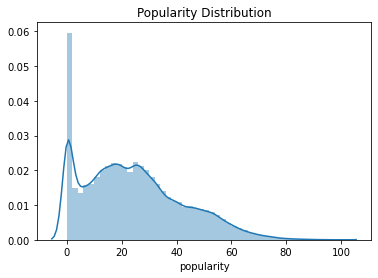

In [4]:
pop_mean = df['popularity'].mean()
print(f"La popularité moyenne est {pop_mean}")

sns.distplot(df['popularity']).set_title('Popularity Distribution')

On peut tout de suite voir que la majorité de morceaux ne sont pas populaires (majorité < 40) avec une moyenne de 24. Notre data apparait donc très déséquilibré.

Maintenant on peut visualiser la corrélation des variables.

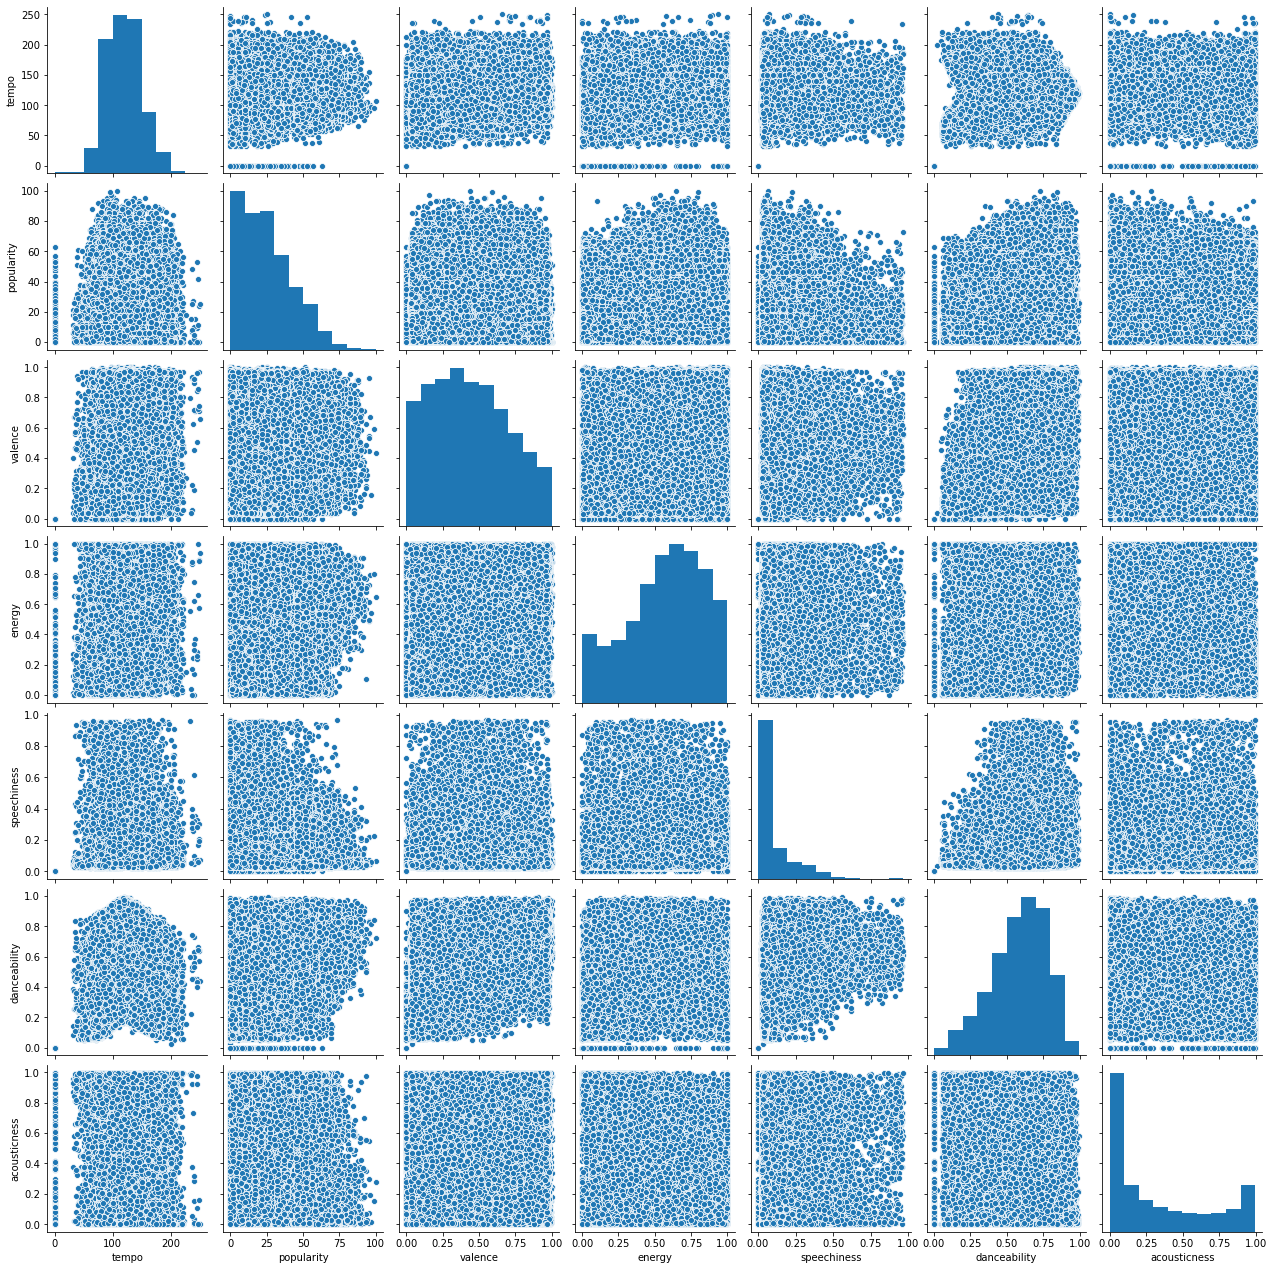

In [5]:
sns.pairplot(df,vars=['tempo', 'popularity', 'valence', 'energy', 'speechiness', 'danceability', 'acousticness'])

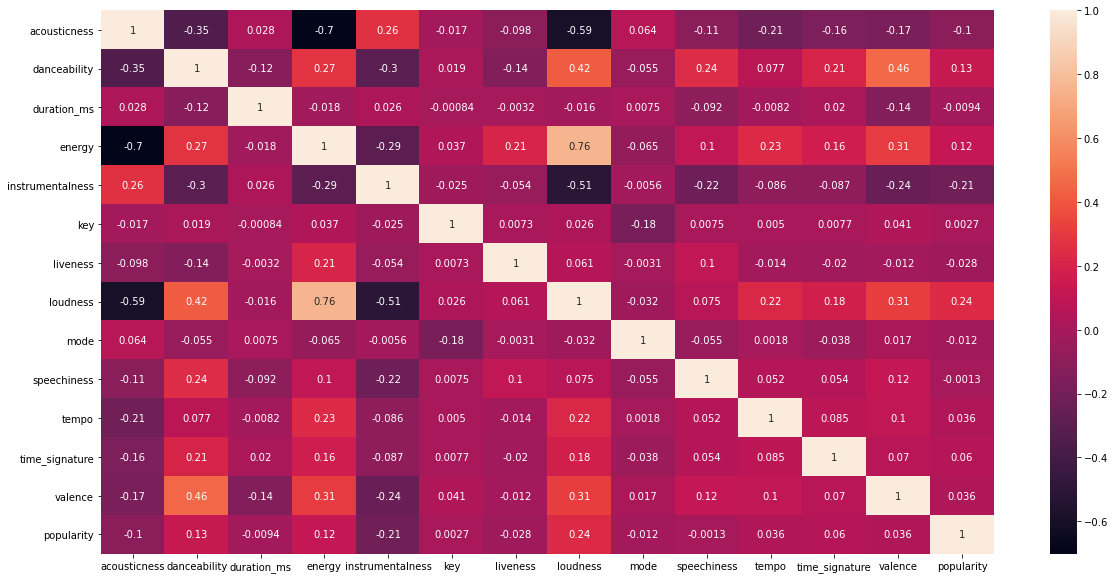

In [6]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(),annot = True)

Alors on peut remarquer:

- Energy et Loudness ont le plus de corrélation positive ce qui parait logique
- Energy et Acousticness ont une corrélation négative très élevée.

Le problème principal ici c'est le manque de corrélation entre nos variables et la popularité. Ce qui veut dire qu'un modèle de régression linéaire aura du mal. Pour l'instant on note que les 4 meilleures caractéristiques (plus de corrélation avec la popularité) sont:

- Energy
- Danceability
- Loudness
- Instrumentalness

## Premier modèle: Régression Linéaire

Pour prédire le score éxacte de la popularité d'un morceau, un modèle de régression linéaire semblait convenable. En revanche, on n'a pas observé beaucoup de correlation entre les variables indépendants et la popularité. On va quand même tenter ce modèle mais d'abord il faut changer les variables catégoriques en dummy variables.

In [7]:
df.columns
df = pd.get_dummies(df, columns=['time_signature', 'key', 'mode'], drop_first=True)

Pour l'instant on gardera tous nos features et on fera un train-test split de 70-30.

In [8]:
features = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", 
            "key_1", "key_2", "key_3", "key_4", "key_5", "key_6", "key_7", "key_8", "key_9", 
            "key_10", "key_11", "liveness", "mode_1", "speechiness", "loudness", "tempo", 
            "time_signature_1", "time_signature_3", "time_signature_4", "time_signature_5", 
            "valence"]
X = df[features]
y = df['popularity']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=8)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.07636941324761426

On obtient un score R^2 très bas. Pas bon signe pour notre modèle.
Nous allons maintenant évaluer ce modèle avec le RMSE.

In [9]:
y_pred = lr.predict(X_test)

In [10]:
from sklearn import metrics
from sklearn.metrics import r2_score

print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

17.116882462613273


Un RMSE de 17.1, alors que la popularité est entre 0-100, est énorme. Même en testant ce modèle avec seulement les 4 meilleures caractéristiques, le score ne s'améliore pas. Il est temps de tester d'autres méthodes de régression. Random Forest pourra aider notre RMSE et permet d'éviter le sur-ajustement.

## Second modèle: RandomForest



In [11]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_estimators=150,
                              max_features=5,
                              oob_score=True,
                              random_state=1)
rfreg.fit(X, y)
pd.DataFrame({'feature':features,
              'importance':rfreg.feature_importances_}).sort_values(by='importance',
                                                                    ascending=False)

,feature,importance
19,loudness,0.129215
2,duration_ms,0.093147
0,acousticness,0.090154
3,energy,0.089425
1,danceability,0.088112
25,valence,0.086973
20,tempo,0.085902
18,speechiness,0.084554
4,instrumentalness,0.079717
16,liveness,0.078923


In [12]:
print((rfreg.oob_score_))

0.15314707692275642


In [13]:
y_pred = rfreg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

6.104699358962384


Le résultat est mieux: 0.15 pour notre OOB et un RMSE de 6.1.
Néanmoins, ce n'est toujours pas un modèle fiable pour bien prédire la popularité d'un morceau. Une solution intéressante pourrait être d'adapter notre cas pour un modèle de classification.

## Troisième modèle: Régression Logistique

Vu les problèmes rencontrés avec nos modèles précédents, nous éxplorons maintenant un modèle de classification: la Régression Logistique. Nous devons créer des catégories pour la popularité car on ne peut plus travailler avec une variable continue.

L'idée est de séparer nos données de popularité en 3 catégories égales: Low, Medium, High.

In [14]:
df['popularity'] = pd.cut(df['popularity'], bins=3, labels = 
                         ["low", "medium", "high"])

In [15]:
df['popularity'].value_counts()

low       84047
medium    30426
high       1899
Name: popularity, dtype: int64

Visiblement notre data est très déséquilibré à travers nos 3 catégories ce qui aura un impact sur un modèle de classification. Pour réduire cela on peut utiliser RandomOverSampler du package imbalanced-learn. De plus, on va utiliser uniquement les 4 meilleurs features identifiés avant.

In [16]:
feature_cols = ['danceability', 'instrumentalness', 'loudness', 'energy']
X = df[feature_cols]

In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

y = df.popularity
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

In [18]:
y_ros.value_counts()

high      84047
medium    84047
low       84047
Name: popularity, dtype: int64

Les 'bins' sont maintenant égaux, on peut établir notre modèle.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.3,
                                                   random_state=42)
from sklearn.linear_model import LogisticRegression

# Instanciate and train the model on the training dataset
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Now make predictions using the trained model on the test dataset
y_pred_logreg = logreg.predict(X_test)
y_pred_logreg_prob = logreg.predict_proba(X_test)

In [20]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score Test: {accuracy_score(y_test, y_pred_logreg)}')
print(f'Accuracy Score Train: {logreg.score(X_train,  y_train)} (as comparison)')

Accuracy Score Test: 0.5142974234231852
Accuracy Score Train: 0.5107026708517943 (as comparison)


In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_logreg))

              precision    recall  f1-score   support

        high       0.50      0.77      0.61     25215
         low       0.64      0.48      0.55     25216
      medium       0.41      0.29      0.34     25212

    accuracy                           0.51     75643
   macro avg       0.52      0.51      0.50     75643
weighted avg       0.52      0.51      0.50     75643



On obtient la meilleure précision pour la classe de basse popularité ce qui est logique vu que ses données ont pas étés touchés par le RandomOverSampling. Alors que le rappel augmente pour la classe (high) qui a été le plus touchée par notre sur-échantillonage.

In [22]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, y_pred_logreg)
#print(cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Score: {}'.format(np.divide(np.sum([cmat[0,0], cmat[1,1], cmat[2,2]]), 
                                            np.sum(cmat)))) 
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[1,0], cmat[0,1], cmat[0,2], 
                                                            cmat[2,0], cmat[1,2], cmat[2,1]]),
                                                    np.sum(cmat))))

TP - True Negative 19322
FP - False Positive 1159
FN - False Negative 7036
TP - True Positive 12221
Accuracy Score: 0.5142974234231852
Misclassification Rate: 0.48570257657681476


Notre performance n'est toujours pas satisfaisante. Il est temps de changer de modèle et se servir de hyper-parameter tuning.

## Quatrième modèle: KNN Classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier

#instanciate and train the model
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

#make predictions
y_pred_knn = knn.predict(X_test)
y_pred_knn_prob = knn.predict_proba(X_test)

#model evaluation
print(f'Accuracy Score Test: {accuracy_score(y_test, y_pred_knn)}')
print(f'Accuracy Score Train: {knn.score(X_train,  y_train)} (as comparison)')

Accuracy Score Test: 0.7581666512433404
Accuracy Score Train: 0.84130698364854 (as comparison)


On a nettement amélioré notre performance même s'il y a du sur-ajustement. Afin de booster encore plus notre accuracy, on va faire du hypertuning pour trouver les meilleurs parametres avec GridSearchCV.

In [24]:
from sklearn.model_selection import GridSearchCV

# define parameter grid for GridSearch and instanciate and train model
param_grid = {'n_neighbors': np.arange(1,30)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

#make predictions
y_pred_knn_tuned = knn_cv.predict(X_test)
y_pred_knn_tuned_prob = knn_cv.predict_proba(X_test)

print('KNN best number of neighbours:',knn_cv.best_params_,'\n')

#model evaluation
print(f'Accuracy Score Test: {accuracy_score(y_test, y_pred_knn_tuned)}')
print(f'Accuracy Score Train: {knn_cv.score(X_train,  y_train)} (as comparison)')

KNN best number of neighbours: {'n_neighbors': 1} 

Accuracy Score Test: 0.8654469018944251
Accuracy Score Train: 0.9992804451041938 (as comparison)


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_knn_tuned))

              precision    recall  f1-score   support

        high       0.98      1.00      0.99     25215
         low       0.88      0.70      0.78     25216
      medium       0.76      0.90      0.82     25212

    accuracy                           0.87     75643
   macro avg       0.87      0.87      0.86     75643
weighted avg       0.87      0.87      0.86     75643



In [26]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, y_pred_knn_tuned)
#print(cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Score: {}'.format(np.divide(np.sum([cmat[0,0], cmat[1,1], cmat[2,2]]), 
                                            np.sum(cmat)))) 
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[1,0], cmat[0,1], cmat[0,2], 
                                                            cmat[2,0], cmat[1,2], cmat[2,1]]),
                                                     np.sum(cmat))))

TP - True Negative 25200
FP - False Positive 0
FN - False Negative 448
TP - True Positive 17572
Accuracy Score: 0.8654469018944251
Misclassification Rate: 0.13455309810557486


Ce modèle là est visiblement le plus performant. Toujours du sur-ajustement mais un score de 86% est le meilleur qu'on ait obtenu.

## Evaluation

Le modèle à choisir est bien le KNN classifier. On obtient un score convenable avec celui-ci mais ce cas a été très simplifié pour l'adapter a un modèle de classification. Prédire entre 3 classes est beaucoup plus facile pour un modèle que de prédire un score exacte de popularité entre 0-100.

De plus, on a choisi de résoudre notre problème de données déséquilibrées avec du sur-échantillonage aléatoire alors que peut-être du sous-échantillonage aurait mieux marché. Avoir moins de données pourrait être preferable aux valeurs synthetiques duplicatives.

Finalement, les caractéristiques fournises par Spotify sont limitées. Il manque d'autres facteurs qui jouent un rôle important dans le succés d'un morceau.

- Le genre du morceau?
- La notoriété de l'artiste?
- Le marketing du morceau?

Il serait très interessant de construire un modèle avec ses nouveaux variables et voir l'effet sur la performance.

De toute façon, un modèle qui prédit correctement la popularité d'un morceau pourrait être très utile pour estimer le revenu potentiel du morceau. Il pourrait également servir pendant la création d'un morceau, comme un feedback loop pour le peaufiner. 